# Teste técnico - Cientista de Dados na 4tune
## Bruno Perdigão de Oliveira

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("data.csv", index_col=0)

In [3]:
# Create a function to calculate Saver's Match
def calculate_savers_match(initial_age, family_kind, marital_status, accumulated_capital, annual_contribution, income):
    n_years = int(65 - initial_age)
    year = 2020
    match_contrib_max = 0.00
    match_contrib_min = 0.50
    max_match = 10000.00
    additional_savings = 0.00
    inflation = 0.044

    # Assuming that "Husband-Wife" means "married couples filing jointly"
    if family_kind == 1:
        phase_out_min = 41000.00
        phase_out_max = 71000.00
        
    # Assuming that not married "Male-led" or "Female-led" means "married person filing separately", which is equivalent to "single"
    elif (family_kind != 1) & (marital_status == 1):
        phase_out_min = 20500.00
        phase_out_max = 35500.00
        
    # Assuming that all the rest are "head-of-household filers"
    else:
        phase_out_min = 30750.00
        phase_out_max = 53250.00

    for i in range(n_years):
        # Saver's Match is only applied from 2027
        if year >= 2027:
            contribution_amount = income * annual_contribution

            if contribution_amount > max_match:
                contribution_amount = max_match
            
            match_perc = np.interp(income,
                                     [phase_out_min, phase_out_max],
                                     [match_contrib_min, match_contrib_max])

            additional_match = match_perc * contribution_amount

            additional_savings += additional_match

            # Phase-out range will only be adjusted from 2028
            phase_out_min += phase_out_min * inflation
            phase_out_max += phase_out_max * inflation

        year += 1
        income += income * inflation     

    return additional_savings

In [4]:
# Applying the function into the dataframe
df['additional_retirement_savings'] = df.apply(lambda x: calculate_savers_match(
                                                            x['initial_age'], 
                                                            x['family_kind'], 
                                                            x['marital_status'],
                                                            x['accumulated_capital'], 
                                                            x['annual_contribution'], 
                                                            x['income']), 
                                                            axis=1)

In [5]:
# Creating a columns with age cohort
bins = [34, 39, 44, 49, 54, 59, 64]
labels = ["34-39","40-44","45-49","50-54","55-59","60-64",]
df["age_cohort"] = pd.cut(df['initial_age'], bins=bins, labels=labels)

In [6]:
# Creating a columns with new_accumulated_capital
df["new_accumulated_capital"] = df.eval('accumulated_capital + additional_retirement_savings')

In [7]:
# Calculating Retirement Readness Rating
df.query("new_accumulated_capital >= 0")['weight'].sum()

able_to_afford = df.query("accumulated_capital >= 0")['weight'].sum()
new_able_to_afford = df.query("new_accumulated_capital >= 0")['weight'].sum()
n_people = df['weight'].sum()
rrr = able_to_afford / n_people
new_rrr = new_able_to_afford / n_people
df['rrr'] = rrr
df['new_rrr'] = new_rrr
df

,initial_age,weight,family_kind,race,marital_status,accumulated_capital,annual_contribution,income,additional_retirement_savings,age_cohort,new_accumulated_capital,rrr,new_rrr
0,57,616,2,1,3,-153263.200759,0.23,42658.02,0.000000,55-59,-153263.200759,0.589664,0.604538
1,45,591,1,1,1,161474.307306,0.24,248327.61,0.000000,45-49,161474.307306,0.589664,0.604538
2,59,613,1,1,1,14209.331170,0.09,24371.94,0.000000,55-59,14209.331170,0.589664,0.604538
3,62,656,1,1,1,-77270.897162,0.17,48788.04,0.000000,60-64,-77270.897162,0.589664,0.604538
4,45,567,2,1,5,282353.182490,0.22,47808.66,0.000000,45-49,282353.182490,0.589664,0.604538
...,...,...,...,...,...,...,...,...,...,...,...,...,...
47621,57,338,1,4,1,78981.212968,0.33,141575.22,0.000000,55-59,78981.212968,0.589664,0.604538
47622,41,350,3,4,3,31142.729450,0.34,141479.43,0.000000,40-44,31142.729450,0.589664,0.604538
47623,56,347,3,4,3,-208621.026557,0.09,33780.18,1416.251380,55-59,-207204.775176,0.589664,0.604538
47624,43,255,1,3,1,925647.121780,0.34,176587.72,0.000000,40-44,925647.121780,0.589664,0.604538


In [8]:
# Calculating Weighted Average Retirement Savings Shortfall by Race and Age Cohort
deficits_df = df.query("new_accumulated_capital < 0").copy()
deficits_df['total_deficits'] = deficits_df.eval("new_accumulated_capital * weight")
group_df = deficits_df.groupby(['race', 'age_cohort']).sum()
group_df["weighted_rss"] = group_df.eval('total_deficits / weight')
group_df

initial_age   weight  family_kind  marital_status  \
race age_cohort                                                      
1    34-39             58610  2205668         2725            3654   
     40-44             79111  2702108         3259            4102   
     45-49             93564  3127675         3457            4252   
     50-54            118087  3898703         4051            4915   
     55-59            116234  3858151         3693            4228   
     60-64             84968  2679299         2653            2964   
2    34-39             13153   616314          866            1328   
     40-44             17243   666486          897            1298   
     45-49             21831   733134         1025            1430   
     50-54             28196   867654         1233            1729   
     55-59             28668   757569         1136            1459   
     60-64             20341   509514          782             976   
3    34-39             27347  1052231         1417            2027   
     40-44             31023   979326         1378            1798   
     45-49             31208   888311         1190            1497   
     50-54             30942   801617         1081            1331   
     55-59             25035   631435          880            1060   
     60-64             18555   425904          592             684   
4    34-39              8402   308353          436             621   
     40-44             10316   301436          451             581   
     45-49             11883   316199          447             557   
     50-54             16100   397192          574             673   
     55-59             14219   286736          473             522   
     60-64             10016   203964          318             357   

                 accumulated_capital  annual_contribution        income  \
race age_cohort                                                           
1    34-39             -2.042163e+08               264.90  1.187561e+08   
     40-44             -2.346004e+08               322.98  1.400131e+08   
     45-49             -2.540979e+08               343.37  1.421094e+08   
     50-54             -2.848332e+08               404.04  1.626108e+08   
     55-59             -2.484690e+08               353.37  1.421678e+08   
     60-64             -1.631841e+08               239.76  9.644250e+07   
2    34-39             -4.735114e+07                61.65  2.517245e+07   
     40-44             -5.294208e+07                71.28  3.060567e+07   
     45-49             -5.861332e+07                76.88  3.337511e+07   
     50-54             -7.314116e+07                90.89  3.898038e+07   
     55-59             -6.438454e+07                90.96  3.434758e+07   
     60-64             -4.287479e+07                56.91  2.427396e+07   
3    34-39             -9.681496e+07               125.80  5.799700e+07   
     40-44             -1.014958e+08               132.22  5.610135e+07   
     45-49             -8.900817e+07               114.92  4.677812e+07   
     50-54             -7.560128e+07               104.81  4.378779e+07   
     55-59             -5.334633e+07                80.12  3.243628e+07   
     60-64             -4.036153e+07                54.49  2.159447e+07   
4    34-39             -2.903787e+07                39.30  1.708698e+07   
     40-44             -3.108907e+07                42.95  1.777527e+07   
     45-49             -3.096281e+07                43.10  1.691891e+07   
     50-54             -3.630248e+07                55.98  2.094020e+07   
     55-59             -3.081092e+07                43.11  1.769697e+07   
     60-64             -2.150800e+07                29.09  1.138953e+07   

                 additional_retirement_savings  new_accumulated_capital  \
race age_cohort                                                           
1    34-39                        1.848902e+07            -1.857273e+08   
     40-44          

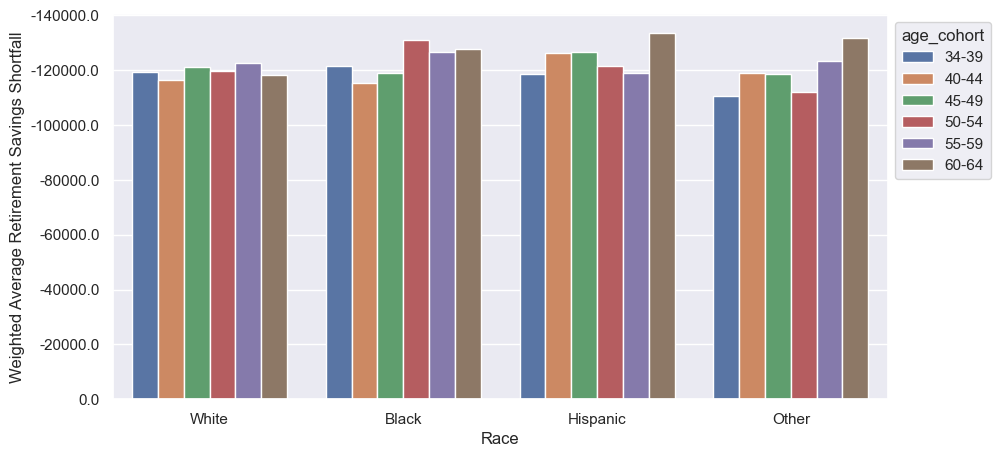

In [9]:
# Plot 1

fig, ax = plt.subplots(figsize=(10, 5))

ax.ticklabel_format(style='plain', axis='y')
ax.invert_yaxis()


plot = sns.barplot(group_df.reset_index(), x='race', y='weighted_rss', hue='age_cohort')

plot.set_xlabel("Race")
plot.set_ylabel("Weighted Average Retirement Savings Shortfall")

ylabels = [f"{y/1:.1f}" for y in ax.get_yticks()]
xlabels = {1:"White", 2:"Black", 3:"Hispanic", 4:"Other"}
plot.set_xticklabels(xlabels.values())
plot.set_yticklabels(ylabels)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

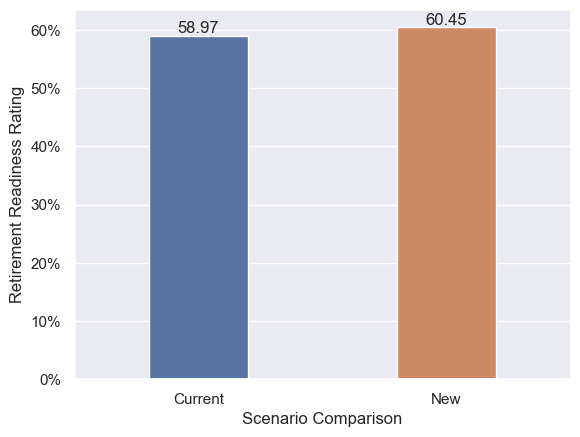

In [10]:
# lot 2
df_rrr = df[['rrr', 'new_rrr']] *100


plot = sns.barplot(df_rrr, width=0.4)
ylabels = [f"{y:.0f}%" for y in plot.get_yticks()]
plot.set_yticklabels(ylabels)
xlabels = ["Current", "New"]
plot.set_xticklabels(xlabels)

plot.set_xlabel("Scenario Comparison")
plot.set_ylabel("Retirement Readiness Rating")

for i in plot.containers:
    plot.bar_label(i, fmt="%.2f")



In [11]:
# Exporting to CSV
final_df = df.drop(['age_cohort', 'additional_retirement_savings', 'rrr', 'new_rrr'], axis=1)
final_df.to_csv("new_scenario.csv")